<h1 align="center" style="color: yellow"> Denoising CNN-Based Autoencoder<h1>


# Imports

In [1]:
import sys
import keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))
print("GPU is", "available" ,gpu)

Python Platform: macOS-13.0-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.8.16 (default, Jan 17 2023, 16:39:35) 
[Clang 14.0.6 ]
Pandas 1.5.2
Scikit-Learn 1.2.1
SciPy 1.10.0
GPU is available 1


In [2]:
import keras
from keras import layers
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

# Dataset

In [3]:
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train[:10000].astype('float32') / 255.
x_test = x_test[:10000].astype('float32') / 255.
print(len(x_train),len(x_test))


10000 10000


### Train an autoencoder (with CNN layers) to encode and decode an image. The input image will have noise added to it, the type of noise will be discussed below. Essentially, you’ll be training a denoising autoencoder. Then you’ll compare putting noise on an image from outside the dataset, which can be a custom photo you took (like trees, street, dogs in the street, cat, buildings, etc) or an image you chose from an online search and use it to test the auto encoder as follows:
* Add noise to the image, and pass it through the autoencoder (the encoder should work as it
was trained)
* Pass the image as it is without noise through the encoder part, then add noise to the
encoded vector, then decode it.
* Apply point (1), (2) on 3 or more custom images (outside of the dataset) and show and
compare the decoded images with the original.

# Adding Noise to the data

In [4]:
def add_noise(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data
train_data_noisy = add_noise(x_train)
test_data_noisy = add_noise(x_test)

# Autoencoder:
Try to not have too many layers (there is no limitation here), this is to save some computation time
and avoid a bit of possible overfitting. Use whatever activations you see fit.
Train the autoencoder to encode a vector of size between 8-16 (a small) and 32-80 (a moderate
size). So, you will need 2 auto encoders.
Save the autoencoders after training them.
Remember that the autoencoder is training on returning (image + noise) to (image)

### First Autoencoder (vector = 16)

In [5]:
######### INPUT ##########
encoder_input = keras.Input(shape=(32,32,3))
############ ENCODER ############
encoder = layers.UpSampling2D()(encoder_input)
encoder = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(encoder)
encoder = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(encoder)
encoder = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder)
################################
######### Latent Vector ########
latent = layers.Conv2D(16,kernel_size=3,strides=2,padding='same',activation='relu',name="latent")(encoder)
# 16,16,16
"""
latent = layers.Flatten()(encoder)
latent = layers.Dense(16,activation='relu')(latent)
latent = layers.Dense(8*8*32,activation='relu')(latent)
latent = layers.Reshape((8, 8, 32))(latent)
"""
#################################
############ DECODER ############
decoder = layers.BatchNormalization()(latent)
decoder = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='sigmoid')(decoder)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.UpSampling2D()(decoder)
decoder = layers.Conv2D(32,  kernel_size=3, strides=2, padding='same', activation='sigmoid')(decoder)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.UpSampling2D()(decoder)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.UpSampling2D()(decoder)
decoder = layers.Conv2D(3,  kernel_size=1, strides=2, padding='same', activation='sigmoid')(decoder)
###############AUTOENCODER###############
Autoencoder16 = keras.Model(encoder_input,decoder)
Autoencoder16.compile(optimizer='adam', metrics=['accuracy'], loss='mse')
Autoencoder16.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 latent (Conv2D)             (None, 16, 16, 16)    

2023-05-17 01:09:13.501619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-17 01:09:13.501720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Second Autoencoder (vector = 80)

In [6]:
######### INPUT ##########
encoder_input = keras.Input(shape=(32,32,3))
############ ENCODER ############
encoder = layers.UpSampling2D()(encoder_input)
encoder = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(encoder)
encoder = layers.BatchNormalization()(encoder)
encoder = layers.UpSampling2D()(encoder)
encoder = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(encoder)
encoder = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(encoder)
################################
######### Latent Vector ########
latent = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu',name="latent")(encoder) # 32,32,32

"""
latent = layers.Flatten()(encoder)
latent = layers.Dense(80,activation='relu')(latent)
latent = layers.Dense(8*8*32,activation='relu')(latent)
latent = layers.Reshape((8, 8, 32))(latent)
"""
#################################
############ DECODER ############
decoder = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='sigmoid')(latent)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.UpSampling2D()(decoder)
decoder = layers.Conv2D(32,  kernel_size=3, strides=2, padding='same', activation='sigmoid')(decoder)
decoder = layers.BatchNormalization()(decoder)
decoder = layers.UpSampling2D()(decoder)
decoder = layers.Conv2D(3,  kernel_size=1, strides=2, padding='same', activation='sigmoid')(decoder)
###############AUTOENCODER###############
Autoencoder80 = keras.Model(encoder_input,decoder)
Autoencoder80.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
Autoencoder80.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 64, 64, 3)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 up_sampling2d_5 (UpSampling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                           

## *******Fitting*******

In [7]:
Autoencoder16.fit(train_data_noisy, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(test_data_noisy, x_test))


Epoch 1/5


2023-05-17 01:09:14.036359: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-17 01:09:14.363511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.6885

2023-05-17 01:09:31.386741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 23s 70ms/step - loss: 0.0097 - accuracy: 0.6885 - val_loss: 0.0492 - val_accuracy: 0.3418
Epoch 2/5
313/313 [==============================] - 20s 65ms/step - loss: 0.0065 - accuracy: 0.7374 - val_loss: 0.0078 - val_accuracy: 0.6966
Epoch 3/5
313/313 [==============================] - 20s 64ms/step - loss: 0.0064 - accuracy: 0.7425 - val_loss: 0.0065 - val_accuracy: 0.6491
Epoch 4/5
313/313 [==============================] - 20s 65ms/step - loss: 0.0063 - accuracy: 0.7450 - val_loss: 0.0067 - val_accuracy: 0.6770
Epoch 5/5
313/313 [==============================] - 20s 64ms/step - loss: 0.0063 - accuracy: 0.7474 - val_loss: 0.0057 - val_accuracy: 0.7584


In [8]:
Autoencoder80.fit(train_data_noisy, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(test_data_noisy, x_test))

Epoch 1/5


2023-05-17 01:10:58.278043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 0.5614 - accuracy: 0.6886

2023-05-17 01:11:36.433380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 51s 160ms/step - loss: 0.5614 - accuracy: 0.6886 - val_loss: 0.6543 - val_accuracy: 0.3838
Epoch 2/5
313/313 [==============================] - 49s 157ms/step - loss: 0.5550 - accuracy: 0.7275 - val_loss: 0.5650 - val_accuracy: 0.7517
Epoch 3/5
 91/313 [=======>......................] - ETA: 27s - loss: 0.5564 - accuracy: 0.7323

KeyboardInterrupt: 

# Prediction

In [ ]:

decoded_imgs16 = Autoencoder16.predict(test_data_noisy)
decoded_imgs80 = Autoencoder80.predict(test_data_noisy)


313/313 [==============================] - 2s 8ms/step


# *** Plotting Noised Images, Denoised and Original ***

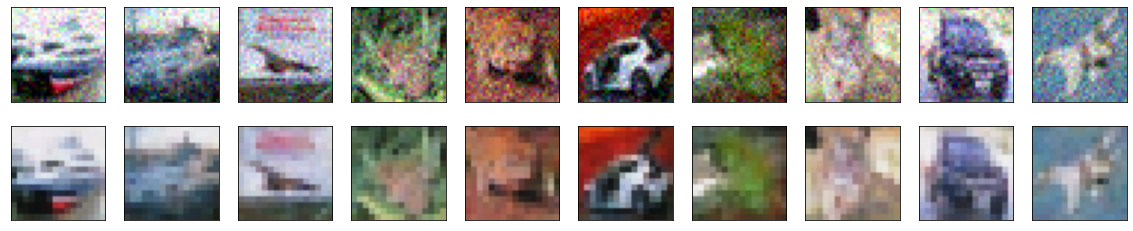

In [ ]:

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data_noisy[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs16[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

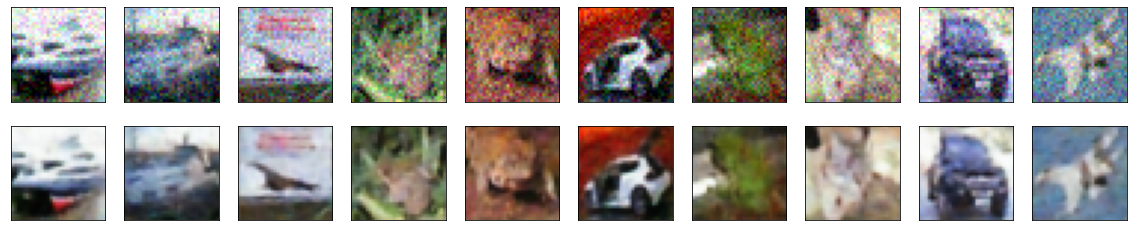

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data_noisy[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs80[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()